# Notes

TODO

In [1]:
import os 
import re
import csv
import json
import math
from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import tsaug
from tsaug.visualization import plot
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

import tsaug
from tsaug.visualization import plot

# Constants

In [70]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [94]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients_with_age')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

In [95]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_no-aug_002')

# Data prep

In [96]:
from utils.input import setup, exercise_to_input

In [97]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [98]:
exercise_source = dir_exercises
#dir_exercises
#dir_exercises_test

In [99]:
#type4-with-fe_no-aug_002
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': False,
    'distance': False,
    'symetry_diference': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [100]:
def raw_data(dir_exercises, file_name):
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r'))
    
    patient_id = get_patient_id(file_name)
    session_id = get_session_id(file_name)
    exercise_id = exercise['meta']['id']
    
    if patient_id not in patients_sessions:
        patients_sessions[patient_id] = {}
        
    if session_id not in patients_sessions[patient_id]:
        patients_sessions[patient_id][session_id] = {}
        
    data = []
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        if poi not in exercise['pois']:
            print(f'!WARNING: {poi} is not present in {file_name}')
            continue
            
        data.append({
            'xs': exercise['pois'][poi]['xs'],
            'ys': exercise['pois'][poi]['ys'],
            'zs': exercise['pois'][poi]['zs']
        })
    
    
    return data     

In [101]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()


for file_name in os.listdir(exercise_source):
    file_path = os.path.join(exercise_source, file_name)

    if file_name == '.DS_Store': continue

    _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

    yslist.append(_ys)
    xslist_meta.append(_xs_meta)  
    xslist_global.append(_xs_global)
    xslist_frontal.append(_xs_frontal)
    xslist_oral.append(_xs_oral)
    xslist_orbital.append(_xs_orbital)

    exercise_id = file_name.split('_')[-1].split('.')[0]
    #print(f'File name {file_name} exercise: {exercise_id}')
    #if exercise_id == '0':
        #print(f'<---------------{file_name}')
        #plot(_xs_global[0])
        #print('----------------->')
        
ys = np.array(yslist, dtype='int')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(2419,)
(2419, 52)
(2419, 126, 600)
(2419, 36, 600)
(2419, 42, 600)
(2419, 48, 600)


# Inference

## Load Model

In [102]:
model = tf.keras.models.load_model(dir_model)

In [103]:
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 126, 600)]   0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 36, 600)]    0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 42, 600)]    0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 48, 600)]    0           []                               
                                                                                           

## Infer

In [104]:
y_pred = model.predict([
    xs_meta,
    xs_global,
    xs_frontal,
    xs_oral,
    xs_orbital],verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(ys, y_pred_bool))

2024-09-25 16:31:23.311956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1098
           1       0.89      0.92      0.90       344
           2       0.95      0.91      0.93       365
           3       0.95      0.95      0.95       153
           4       0.95      0.92      0.93       144
           5       0.96      0.92      0.94       315

    accuracy                           0.94      2419
   macro avg       0.94      0.93      0.93      2419
weighted avg       0.94      0.94      0.94      2419



# Visualize patient exercises

In [105]:
from operator import attrgetter

In [106]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [107]:
exercises_number = 9

In [108]:
def confusion_fn(pred):
    y = np.argmax(pred, axis=1)
    if y[0] == 0:
        confusion_arr = np.sum(pred, axis=1) - pred[0][y[0]]
        return confusion_arr[0]
    
    return (y[0]+1) - pred[0][0]

## Single patient with details

In [113]:
def inference_results_patient(patient_id, session_id):
    results = []


    for exercise_id in range(1, exercises_number + 1):
        file_name = os.path.join(
            exercise_source, 
            f'{patient_id}_{session_id}_0{exercise_id}.json'
        )
                
        if not os.path.isfile(file_name):
            print(f'File {file_name} is missing')
            continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_name, feature_engineering_setting)

        xs_meta = np.array([_xs_meta], dtype='float32')   
        xs_global = np.array([_xs_global], dtype='float32') 
        xs_frontal = np.array([_xs_frontal], dtype='float32') 
        xs_oral = np.array([_xs_oral], dtype='float32') 
        xs_orbital = np.array([_xs_orbital], dtype='float32')         
        
        ys_pred = model.predict([
            xs_meta,
            xs_global,
            xs_frontal,
            xs_oral,
            xs_orbital],verbose=0)
        
        y_pred = np.argmax(ys_pred, axis=1)
        
        confusion = confusion_fn(ys_pred)
        
        data = json.load(open(file_name, 'r'))
        
        if data['meta']['age'] and data['meta']['age'] != 'None':
            results.append({
                'patient_id': patient_id,
                'exercise_id': exercise_id,
                'confusion': confusion,
                'inference': y_pred[0],
                'age': float(data['meta']['age']),
                'age_bucket': int(float(data['meta']['age']) // 10)
            })
    
    return results

In [114]:
def plot_patient(patient_id, session_id):
    exercises_result = []
    results = []
    fig, axs = plt.subplots(1,9,figsize=(15,2)) 


    for exercise_id in range(1, exercises_number + 1):
        file_name = os.path.join(
            exercise_source, 
            f'{patient_id}_{session_id}_0{exercise_id}.json'
        )
                
        if not os.path.isfile(file_name):
            print(f'File {file_name} is missing')
            continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_name, feature_engineering_setting)


        xs_meta = np.array([_xs_meta], dtype='float32')   
        xs_global = np.array([_xs_global], dtype='float32') 
        xs_frontal = np.array([_xs_frontal], dtype='float32') 
        xs_oral = np.array([_xs_oral], dtype='float32') 
        xs_orbital = np.array([_xs_orbital], dtype='float32')         
        
        ys_pred = model.predict([
            xs_meta,
            xs_global,
            xs_frontal,
            xs_oral,
            xs_orbital],verbose=0)
        
        #print(ys_pred[0][0])
        y_pred = np.argmax(ys_pred, axis=1)
        
        confusion = confusion_fn(ys_pred)
        
        print(f'file: {file_name} pred: {y_pred} real: {_ys} confusion: {confusion}')
        exercises_result.append(list(ys_pred[0]))

        axs[exercise_id].bar(1 + np.arange(6), ys_pred[0], width=1, edgecolor="white", linewidth=0.7)

        axs[exercise_id].set(
            xlim=(0, 7), 
            xticks=np.arange(1, 7),
            ylim=(0, 1))
        
        results.append({
            'patient_id': patient_id,
            'exercise_id': exercise_id + 1,
            'file': f'{patient_id}_{patient_id}_{exercise_id}.json',
            'inference': list(ys_pred[0]),
            'confusion': confusion
        })

    plt.show()    
    
    return results

In [115]:
def all_patients():
    ids = set()
    for file in os.listdir(exercise_source):
        id = file.split('_')[0]
        session_id = file.split('_')[1]
        ids.add((id, session_id))
    
    return sorted(ids, key=lambda a: a[0])

In [116]:
inference_results = []
patient_ids = all_patients()
for patient_id, session_id in patient_ids:
    inference_results.extend(inference_results_patient(patient_id, session_id))
    
#inference_results to pd
df = pd.DataFrame.from_records(inference_results)  
                             
for exercise_id in range(0, 9):
    print(f'Exercise {exercise_id + 1}')
    ex_df = df.loc[df['exercise_id'] == exercise_id][['age_bucket', 'confusion']]
    grouped_df = ex_df.groupby('age_bucket').agg(['min', 'mean', 'max'])
    print(grouped_df)

File ../data/json/patients_with_age/1_76_07.json is missing
File ../data/json/patients_with_age/1_76_08.json is missing
File ../data/json/patients_with_age/1_76_09.json is missing
File ../data/json/patients_with_age/105_126_07.json is missing
File ../data/json/patients_with_age/105_126_08.json is missing
File ../data/json/patients_with_age/105_126_09.json is missing
File ../data/json/patients_with_age/107_51_04.json is missing
File ../data/json/patients_with_age/107_51_05.json is missing
File ../data/json/patients_with_age/107_51_06.json is missing
File ../data/json/patients_with_age/107_51_07.json is missing
File ../data/json/patients_with_age/107_51_08.json is missing
File ../data/json/patients_with_age/107_51_09.json is missing
File ../data/json/patients_with_age/107_50_01.json is missing
File ../data/json/patients_with_age/107_50_02.json is missing
File ../data/json/patients_with_age/107_50_03.json is missing
File ../data/json/patients_with_age/110_120_03.json is missing
File ../da

In [117]:
import seaborn as sns

In [118]:
grouped_df = df[['exercise_id','age_bucket','confusion']].groupby(['exercise_id','age_bucket']).agg('mean').reset_index()
print(grouped_df.head())

   exercise_id  age_bucket  confusion
0            1           2   0.999143
1            1           3   3.312054
2            1           4   1.623096
3            1           5   1.511366
4            1           6   1.847684


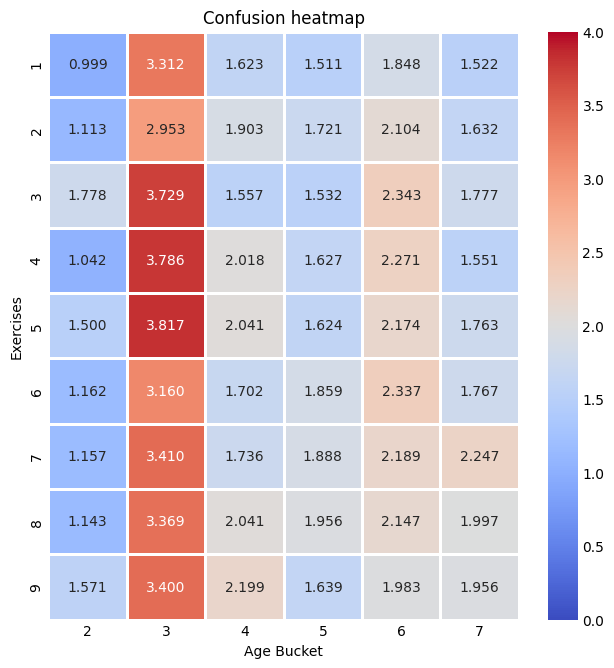

In [119]:
matrix = grouped_df.pivot(index='exercise_id', columns='age_bucket', values='confusion')

fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(matrix, cmap='coolwarm', annot=True, fmt='0.03f',linewidths=1, vmin=0, vmax=4, ax=ax)
#coolwarm
#YlGnBu
ax.set_title('Confusion heatmap')
ax.set(xlabel='Age Bucket', ylabel='Exercises')

fig.savefig(f'heat_map_confusion.svg', format='svg', dpi=1200)


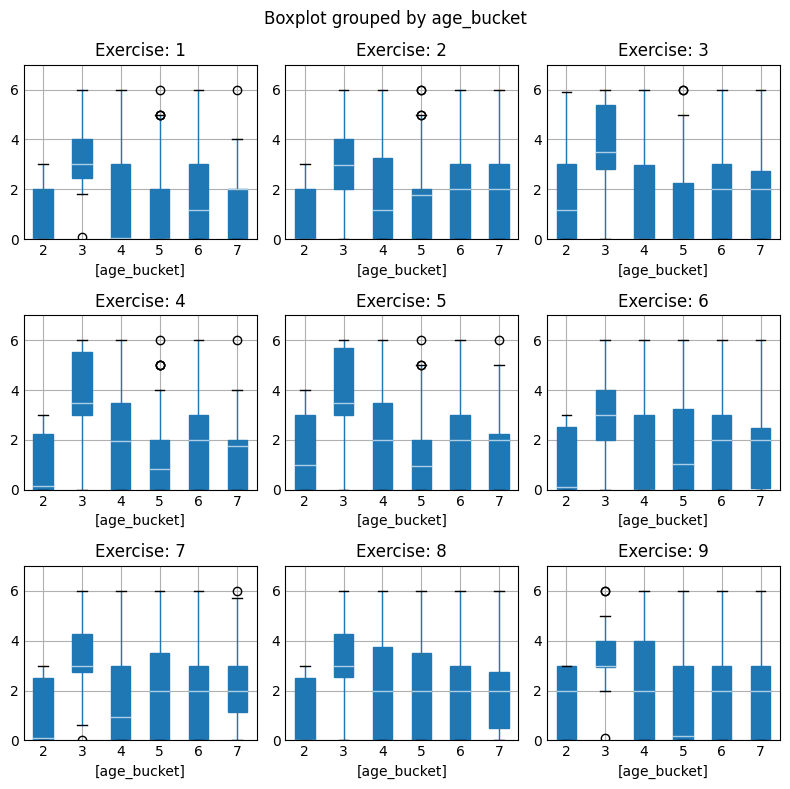

In [120]:
fig, axs = plt.subplots(3,3,figsize=(8,8)) 
for exercise_id in range(0, 9):
    row = exercise_id // 3
    col = exercise_id - (row * 3 )
    ex_df = df.loc[df['exercise_id'] == exercise_id + 1][['age_bucket', 'confusion']]
    plot = ex_df.boxplot(by='age_bucket', ax=axs[row][col], patch_artist=True)
    plot.set_title(f'Exercise: {exercise_id + 1}')
    plot.set_ylim([0, 7])

plt.tight_layout() 
#fig.suptitle('title', y = 'y_title', fontsize=15)
plt.show()
fig.savefig(f'box_plot_confusion.svg', format='svg', dpi=1200)

__END__